## Data Extraction and Cleaning

In [47]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

def extract_text(review_block, header_class, sibling=True):
    for td in review_block.find_all("td", {"class": header_class}):
        if sibling:
            return td.find_next_sibling("td").get_text().strip()
        else:
            return td.get_text().strip()
    return None

def extract_star_rating(review_block, header_class):
    for td in review_block.find_all("td", {"class": header_class}):
        star_elements = td.find_next_sibling("td").find_all("span", {"class": "star fill"})
        return len(star_elements)
    return None

for i in range(1, pages + 1):
    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    
    for review_block in parsed_content.find_all("article", {"itemprop": "review"}):
        review_text = review_block.find("div", {"class": "text_content"}).get_text().strip()
        rating_value = review_block.find("span", {"itemprop": "ratingValue"}).get_text().strip()
        
        # Extract information using helper functions
        aircraft_type = extract_text(review_block, "review-rating-header aircraft")
        traveller_type = extract_text(review_block, "review-rating-header type_of_traveller")
        date_flown = extract_text(review_block, "review-rating-header date_flown")
        seat_comfort = extract_star_rating(review_block, "review-rating-header seat_comfort")
        crew_rating = extract_star_rating(review_block, "review-rating-header cabin_staff_service")
        food_beverage_rating = extract_star_rating(review_block, "review-rating-header food_and_beverages")
        entertainment_rating = extract_star_rating(review_block, "review-rating-header inflight_entertainment")
        ground_service_rating = extract_star_rating(review_block, "review-rating-header ground_service")
        wifi_rating = extract_star_rating(review_block, "review-rating-header wifi_and_connectivity")
        value_rating = extract_star_rating(review_block, "review-rating-header value_for_money")
        
        reviews.append({"review": review_text, "rating": rating_value, "aircraft": aircraft_type, "traveller_type": traveller_type, "date_flown": date_flown, "seat_comfort": seat_comfort, 
                        "crew_rating":crew_rating, "food_beverage_rating":food_beverage_rating, "entertainment_rating":entertainment_rating, "ground_service_rating":ground_service_rating,
                        "wifi_rating":wifi_rating, "value_rating":value_rating})
    
    print(f"   ---> {len(reviews)} total reviews")

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(reviews)

# Convert date_flown to datetime
df['date_flown'] = pd.to_datetime(df['date_flown'], errors='coerce')

# Function to clean review text
def clean_review_text(text):
    # Remove check marks and verification status
    return re.sub(r'(✅\s*Trip Verified\s*\|\s*|Not Verified\s*\|\s*)', '', text)

# Apply the function to the review column
df['review'] = df['review'].apply(clean_review_text)

# Print the first 5 entries to verify
for review in reviews[:5]:
    print("Review:", review["review"])
    print("Rating:", review["rating"])
    print("Aircraft:", review["aircraft"])
    print("Traveller Type:", review["traveller_type"])
    print("Date Flown:", review["date_flown"])
    print("Seat Comfort:", review["seat_comfort"])
    print("Crew Rating:", review["crew_rating"])
    print("Food & Beverage Rating:", review["food_beverage_rating"])
    print("Inflight Entertainment Rating:", review["entertainment_rating"])
    print("Ground Service Rating:", review["ground_service_rating"])
    print("Wifi and Connectivity Rating:", review["wifi_rating"])
    print("Value for Money Rating:", review["value_rating"])
    print("----")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Review: ✅ Trip Verified | My partner and I were on the BA2166 return flight from Tampa to Gatwick and I was very excited as had paid for a upgrade to Business Class, my partner flies BC with BA a lot for work but this was only my second time, we decided as it was the end of our holiday that have this will help us get some quality sleep. Unfortunately that was not to be. Also in Business Class were two families with children under 5. It was a very long flight listening to a toddler not just crying but screaming for seven out of the eight hours. Now its not the childrens fa

C:\Users\annap\AppData\Local\Temp\ipykernel_16252\3504748189.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date_flown'] = pd.to_datetime(df['date_flown'], errors='coerce')


In [60]:
df.to_excel('BA_Cleaned_Dataset.xlsx')

## Text Review Understanding

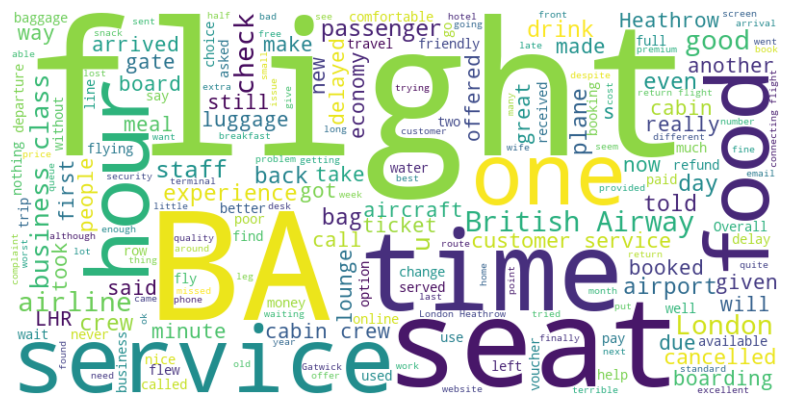

In [49]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all reviews into a single string
text = " ".join(review for review in df['review'])

# Create and generate a word cloud image
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [61]:
from textblob import TextBlob

# Perform sentiment analysis
def get_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis to each review
df[['sentiment_polarity', 'sentiment_subjectivity']] = df['review'].apply(lambda x: pd.Series(get_sentiment(x)))

# Summary statistics for sentiment polarity
polarity_stats = df['sentiment_polarity'].describe()
print("Sentiment Polarity Summary Statistics:")
print(polarity_stats)

# Summary statistics for sentiment subjectivity
subjectivity_stats = df['sentiment_subjectivity'].describe()
print("\nSentiment Subjectivity Summary Statistics:")
print(subjectivity_stats)

# Average sentiment polarity for each rating
average_polarity_by_rating = df.groupby('rating')['sentiment_polarity'].mean()
print("\nAverage Sentiment Polarity by Rating:")
print(average_polarity_by_rating)

# Average sentiment subjectivity for each rating
average_subjectivity_by_rating = df.groupby('rating')['sentiment_subjectivity'].mean()
print("\nAverage Sentiment Subjectivity by Rating:")
print(average_subjectivity_by_rating)

# Count of positive, negative, and neutral reviews
positive_reviews = df[df['sentiment_polarity'] > 0].shape[0]
negative_reviews = df[df['sentiment_polarity'] < 0].shape[0]
neutral_reviews = df[df['sentiment_polarity'] == 0].shape[0]

print(f"\nCount of Positive Reviews: {positive_reviews}")
print(f"Count of Negative Reviews: {negative_reviews}")
print(f"Count of Neutral Reviews: {neutral_reviews}")

Sentiment Polarity Summary Statistics:
count    1000.000000
mean        0.063205
std         0.199347
min        -0.766667
25%        -0.050132
50%         0.047956
75%         0.178310
max         0.715000
Name: sentiment_polarity, dtype: float64

Sentiment Subjectivity Summary Statistics:
count    1000.000000
mean        0.487803
std         0.128749
min         0.000000
25%         0.413079
50%         0.487913
75%         0.565013
max         0.950000
Name: sentiment_subjectivity, dtype: float64

Average Sentiment Polarity by Rating:
rating
1    -0.040886
10    0.297722
2    -0.025281
3     0.003512
4     0.003163
5     0.079794
6     0.102249
7     0.174828
8     0.212413
9     0.303446
Name: sentiment_polarity, dtype: float64

Average Sentiment Subjectivity by Rating:
rating
1     0.455906
10    0.530649
2     0.479369
3     0.492168
4     0.486791
5     0.495384
6     0.512682
7     0.490230
8     0.508016
9     0.560190
Name: sentiment_subjectivity, dtype: float64

Count of Pos

                                 rating  seat_comfort  crew_rating  \
rating                         1.000000      0.754694     0.697914   
seat_comfort                   0.754694      1.000000     0.645686   
crew_rating                    0.697914      0.645686     1.000000   
food_beverage_rating           0.722957      0.679863     0.743678   
entertainment_rating           0.652317      0.714512     0.601420   
...                                 ...           ...          ...   
traveller_type_Family Leisure  0.047437      0.013551     0.055330   
traveller_type_Solo Leisure    0.087397      0.032069    -0.000125   
year                          -0.231243     -0.129882    -0.182213   
month                          0.107849      0.138395     0.075801   
day_of_week                    0.044715      0.070602     0.008726   

                               food_beverage_rating  entertainment_rating  \
rating                                     0.722957              0.652317   
seat_

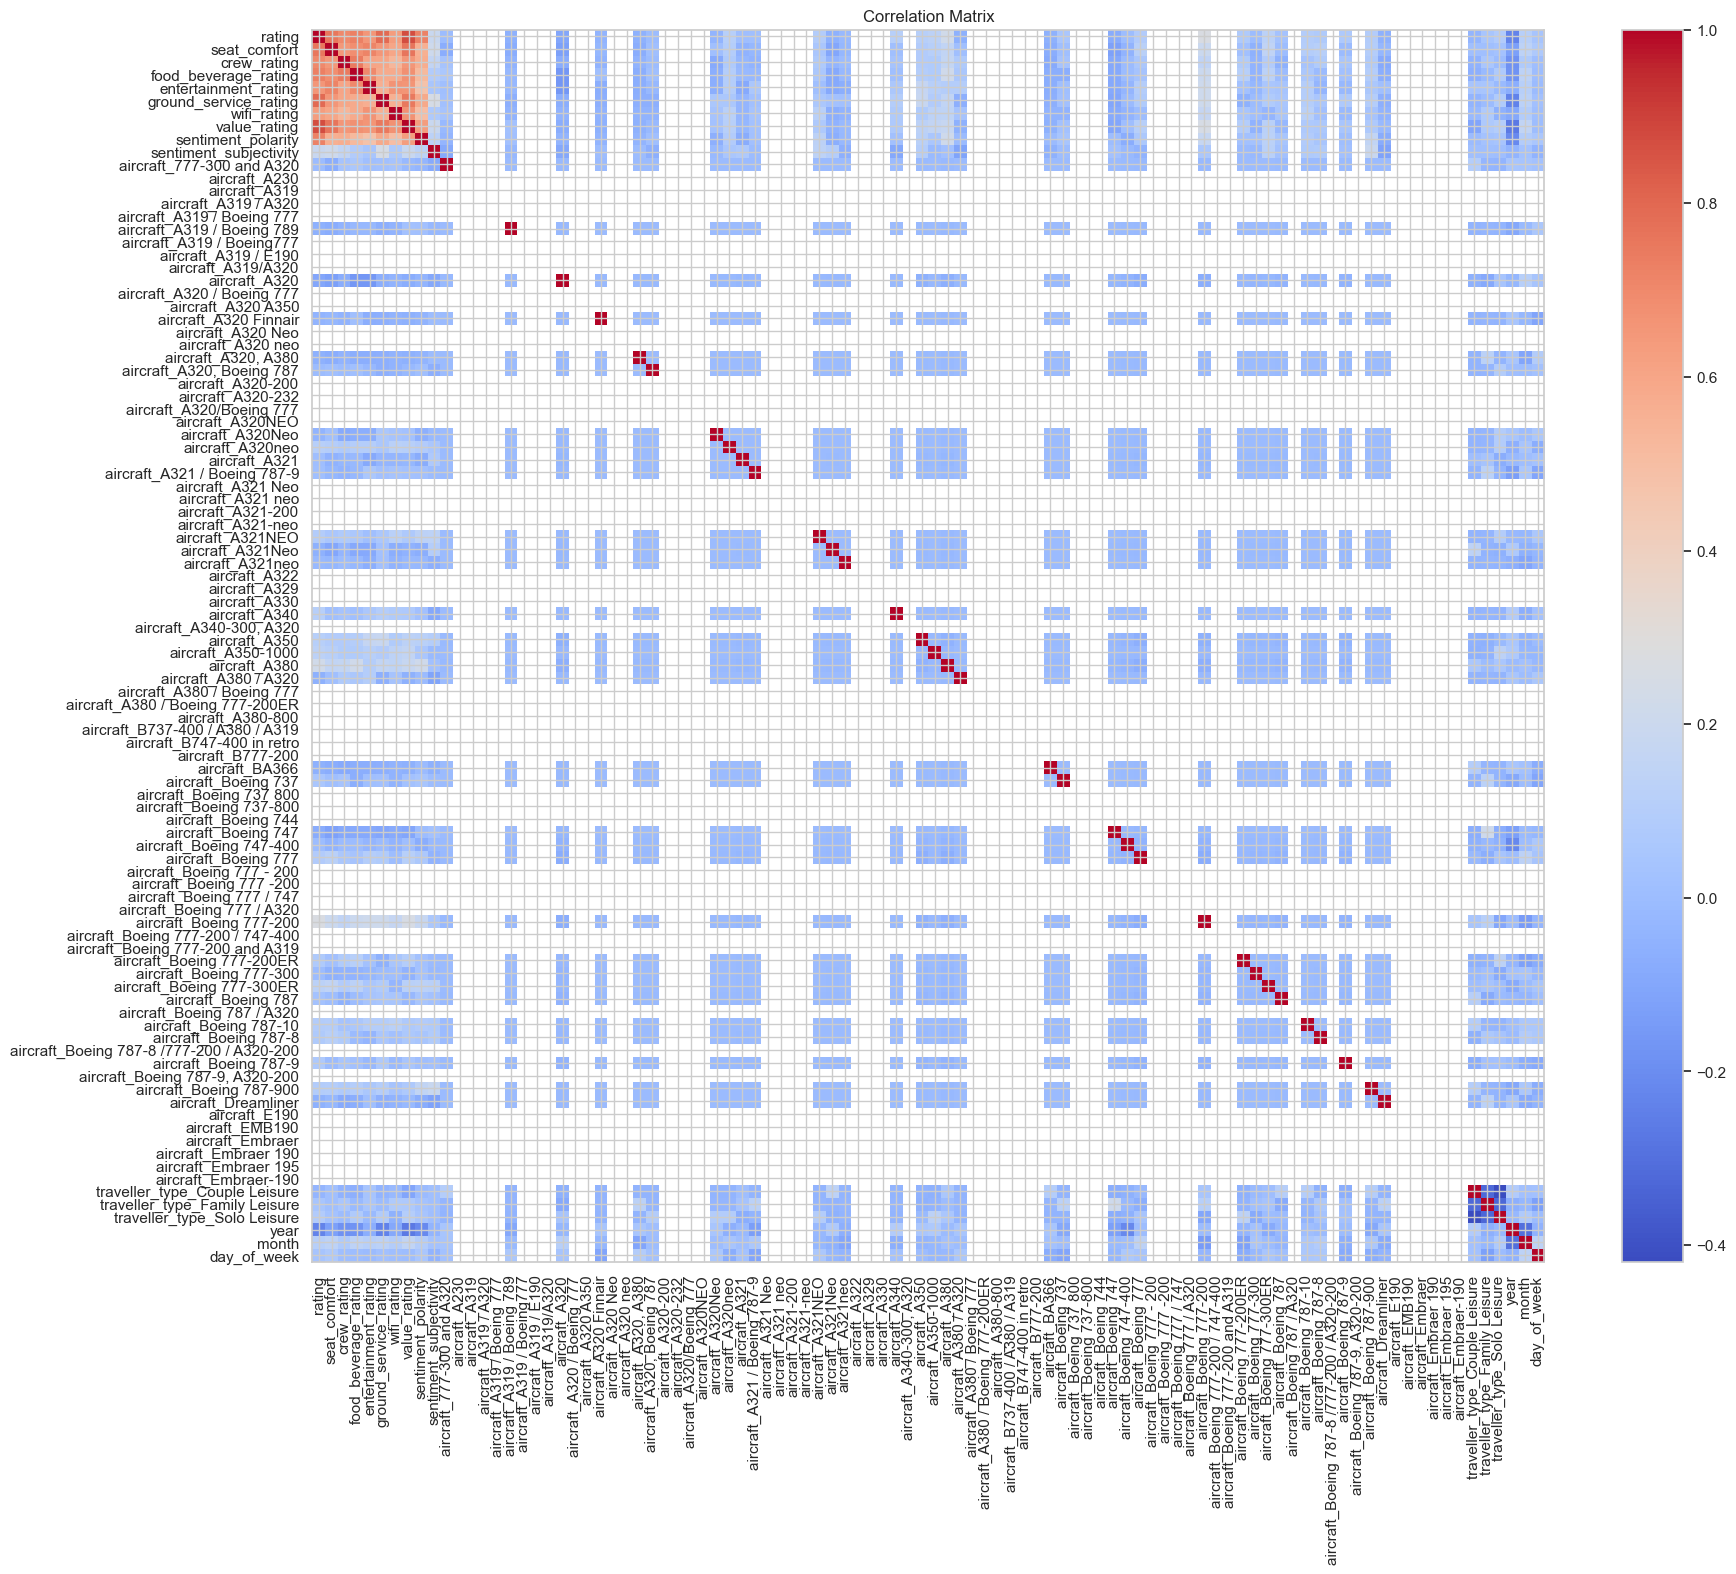

Linear Regression R^2 Score: -2365909205491627.5
Random Forest Regression R^2 Score: 0.817630254260211
Feature Importance:
value_rating                       0.724356
ground_service_rating              0.081894
sentiment_polarity                 0.077238
crew_rating                        0.028804
seat_comfort                       0.017792
                                     ...   
aircraft_B737-400 / A380 / A319    0.000000
aircraft_B747-400 in retro         0.000000
aircraft_B777-200                  0.000000
aircraft_BA366                     0.000000
aircraft_A380-800                  0.000000
Length: 95, dtype: float64


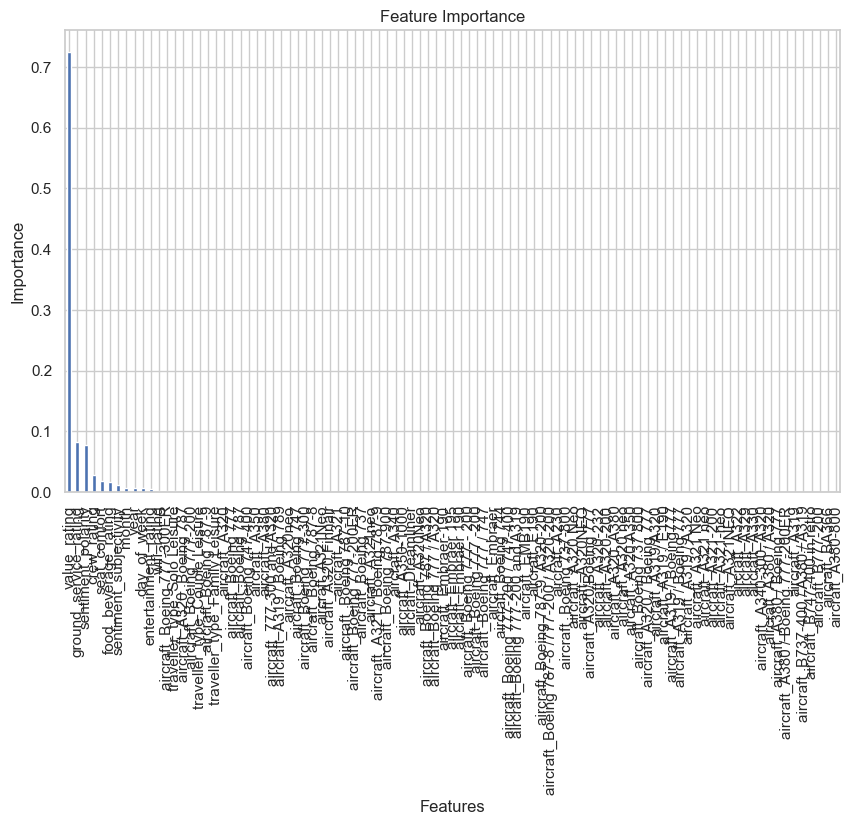

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder

# Extract useful features from the 'date_flown' column
#df['year'] = df['date_flown'].dt.year
#df['month'] = df['date_flown'].dt.month
#df['day_of_week'] = df['date_flown'].dt.dayofweek  # Monday=0, Sunday=6

# Drop the original 'date_flown' column
#df = df.drop(columns=['date_flown'])

# One-hot encode the 'traveller_type' column
#df = pd.get_dummies(df, columns=['traveller_type'], drop_first=True)

df = df.dropna()

# Correlation analysis
correlation_matrix = df.corr()
print(correlation_matrix)

# Visualize correlation matrix
plt.figure(figsize=(20, 16))
plt.imshow(correlation_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(correlation_matrix)), correlation_matrix.columns, rotation=90)
plt.yticks(range(len(correlation_matrix)), correlation_matrix.columns)
plt.title('Correlation Matrix')
plt.show()

# Model building
X = df.drop(columns=['rating'])  # Features
y = df['rating']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_score = lr_model.score(X_test, y_test)
print("Linear Regression R^2 Score:", lr_score)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test)
print("Random Forest Regression R^2 Score:", rf_score)

# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X.columns)
feature_importance_sorted = feature_importance.sort_values(ascending=False)
print("Feature Importance:")
print(feature_importance_sorted)

# Visualize feature importance
plt.figure(figsize=(10, 6))
feature_importance_sorted.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [82]:
df.head()

,rating,seat_comfort,crew_rating,food_beverage_rating,entertainment_rating,ground_service_rating,wifi_rating,value_rating,sentiment_polarity,sentiment_subjectivity,...,aircraft_Embraer,aircraft_Embraer 190,aircraft_Embraer 195,aircraft_Embraer-190,traveller_type_Couple Leisure,traveller_type_Family Leisure,traveller_type_Solo Leisure,year,month,day_of_week
1,1,1.0,1.0,1.0,1.0,1.0,1.0,1,-0.018618,0.560317,...,False,False,False,False,False,True,False,2024,1,0
3,2,2.0,3.0,3.0,5.0,3.0,4.0,3,-0.056360,0.492325,...,False,False,False,False,False,True,False,2024,5,2
4,1,1.0,2.0,1.0,1.0,1.0,2.0,3,-0.032143,0.353571,...,False,False,False,False,False,False,False,2023,10,6
6,2,2.0,1.0,1.0,1.0,1.0,1.0,1,0.102778,0.540278,...,False,False,False,False,False,False,True,2024,5,2
7,3,2.0,3.0,2.0,1.0,2.0,1.0,1,-0.122222,0.564206,...,False,False,False,False,True,False,False,2024,5,2
